<a href="https://colab.research.google.com/github/prateeknigam9/Translator/blob/main/Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Translator Italian to English


In [16]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [17]:
!ls

_about.txt  ita-eng.zip  ita.txt  Translater.ipynb


In [18]:
# !unzip ita-eng.zip

In [19]:
!ls -ltr

total 55543
-rw------- 1 root root 49194161 Jan 24 02:56 ita.txt
-rw------- 1 root root     1441 Jan 24 02:56 _about.txt
-rw------- 1 root root  7567445 May 27 02:44 ita-eng.zip
-rw------- 1 root root   111698 May 30 09:46 Translater.ipynb


## Libraries

In [184]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.ticker as ticker

## Data Gathering

In [21]:
english,italian=[],[]
with open('ita.txt','r',encoding='utf-8') as f:
  for i,val in enumerate(f.readlines()):
    english.append(val.split('\t')[0])
    italian.append(val.split('\t')[1])
    if i > 97 and i <=100:
      print(val.split()[:2])

['Go', 'now.']
['Got', 'it!']
['Got', 'it!']


In [22]:
data = pd.DataFrame()
data['English'] = english
data['italian'] = italian
del english,italian
data.sample(5)

,English,italian
39193,She studies hard.,Studia duramente.
134373,I wasn't busy last week.,Non ero occupato la settimana scorsa.
39607,The door is ajar.,La porta è socchiusa.
321754,Tom stands by me whenever I am in trouble.,Tom è accanto a me ogni volta che sono nei guai.
98739,Can we just skip that?,Possiamo saltarlo e basta?


### Preprocessing

In [23]:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

#replacing contracted words with decontracted
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

# removing extra special characters
def preprocess(text):
    # convert all the text into lower letters
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

# preprocessing for itallian language
def preprocess_ita(text):    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text

In [24]:
data['English'] = data['English'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)

In [25]:
data.sample(3)

,English,italian
326660,the language tom was speaking was not french,la lingua che stava parlando tom non era il fr...
232342,what did you eat this morning,che coshai mangiato questa mattina
8998,identify tom,identificate tom


In [26]:
data.shape

(345244, 2)

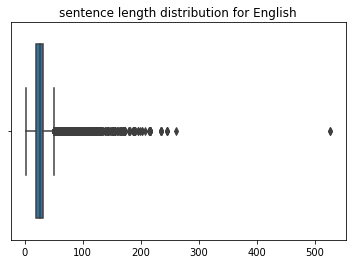

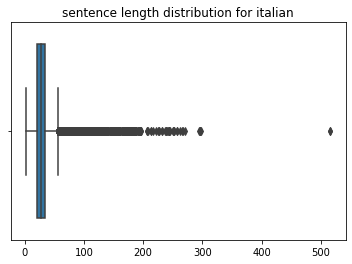

{'English': 26.0, 'italian': 27.0}


In [27]:
length={}
for col in list(data.columns):
    txtlen=[]
    for txt in data[col]:
      txtlen.append(len(txt))
    length[col] = np.median(txtlen)
    sns.boxplot(txtlen)
    plt.title(f'sentence length distribution for {col}')
    plt.show()
print(length)

In [28]:
maxlen=26
data['English_len'] = data['English'].apply(lambda x: len(x.split()))
data['italian_len'] = data['italian'].apply(lambda x: len(x.split()))
data = data[data['English_len'] <maxlen]
data = data[data['italian_len'] <maxlen]
data.shape

(344951, 4)

In [29]:
data = data.drop(['English_len','italian_len'],axis=1)

In [30]:
data.sample(3)

,English,italian
50915,that will not happen,non succederà
118669,i took the last cookie,ho preso lultimo biscotto
50230,please explain it,per piacere spiegatelo


In [31]:
data['english_inp'] = '<start> '+ data['English'].astype('str')
data['english_out'] = data['English'].astype('str')+' <end>'
data= data.drop('English',axis=1)

In [32]:
data.sample(3)

,italian,english_inp,english_out
261853,lo so che mi sta guardando,<start> i know that you are looking at me,i know that you are looking at me <end>
159964,siete sicure che tom sia pronto,<start> are you sure tom is ready,are you sure tom is ready <end>
119750,non sono geloso di tom,<start> i am not jealous of tom,i am not jealous of tom <end>


In [33]:
train,test = train_test_split(data,test_size=0.2)

In [34]:
train.iloc[0]['english_inp'] = train.iloc[0]['english_inp']+' <end>'

In [35]:
print(train.shape,test.shape)

(275960, 3) (68991, 3)


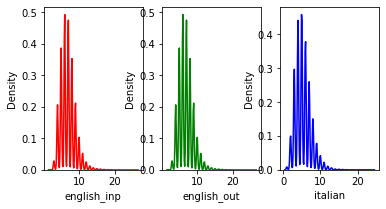

In [36]:
eng_inp = train['english_inp'].str.split().apply(len)
eng_out = train['english_out'].str.split().apply(len)
italian = train['italian'].str.split().apply(len)
plt.figure(figsize=(6,3))
plt.subplot(1,3,1)
sns.kdeplot(eng_inp,color='red')
plt.subplot(1,3,2)
sns.kdeplot(eng_out,color='green')
plt.subplot(1,3,3)
sns.kdeplot(italian,color='blue')
plt.show()

In [37]:
tokenizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_eng.fit_on_texts(train['english_inp'].values)

In [38]:
vocab_eng = len(list(tokenizer_eng.word_index.keys()))

In [39]:
print([(key,val) for key,val in dict(tokenizer_eng.word_index).items()][:5])

[('<start>', 1), ('i', 2), ('you', 3), ('tom', 4), ('to', 5)]


In [40]:
tokenizer_ita = Tokenizer()
tokenizer_ita.fit_on_texts(train['italian'].values)

In [41]:
vocab_ita = len(list(tokenizer_ita.word_index.keys()))

In [42]:
print([(key,val) for key,val in dict(tokenizer_ita.word_index).items()][:5])

[('tom', 1), ('non', 2), ('è', 3), ('di', 4), ('a', 5)]


In [43]:
for i,word in enumerate(list(tokenizer_eng.word_index.keys())):
  if '<' in word:
    print(i,word)

0 <start>
10135 <end>


In [158]:
word_index_dict_eng = {index: word for word, index in tokenizer_eng.word_index.items()}

## Encoder - Decoder Model

In [58]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,LSTM,Dot,Dense

In [171]:
class Encoder(tf.keras.Model):
  '''
  Embedding_layer
  LSTM layer
  '''
  def __init__(self,input_vocab,embedding_dim,input_length,encoder_units):
    super().__init__()
    self.input_vocab = input_vocab
    self.embedding_dim = embedding_dim
    self.input_length = input_length
    self.encoder_units = encoder_units

  def build(self,*params):
    self.embedding_layer = Embedding(input_dim=self.input_vocab,output_dim=self.embedding_dim,input_length=self.input_length,trainable=True,
                                     name = "Encoder_embedding_layer")
    self.lstm_layer  = LSTM(units = self.encoder_units,return_sequences=True,return_state=True,
                            name = "Encoder_lstm_layer")
  def call(self,input_sequence,training=True):
    '''
    ============================== ENCODER ==============================
    INPUT TO ENCODER
    input_sequence:  (16, 100)
    OUTPUT OF ENCODER
    embed_output: (16, 100, 512) (batch_size,input_length,embedding_dim)
    lstm_output:  (16, 100, 50) (batch_size,input_length,lstm_size)
    hidden_state:  (16, 50) (batch_size,lstm_size)
    cell_state:  (16, 50) (batch_size,lstm_size)
    =======================================================================
    '''
    embed_output = self.embedding_layer(input_sequence)
    lstm_output,hidden_state,cell_state = self.lstm_layer(embed_output)

    return lstm_output,hidden_state,cell_state
  
  def initialize_states(self,batch_size):
     hidden_state = tf.zeros((batch_size,self.encoder_units))
     cell_state = tf.zeros((batch_size,self.encoder_units))

     return hidden_state,cell_state

In [137]:
class Attention(layers.Layer):
  '''
  score > attenton_weights > context_vector
  '''
  def __init__(self,attention_units,name = "Attenion_layer"):
    super().__init__()
    self.attention_units = attention_units   
    self.W1 = Dense(self.attention_units)
    self.W2 = Dense(self.attention_units)
    self.V  = Dense(1)

  def call(self,decoder_hidden_state,encoder_output):
    '''
    ============================== Attention ==============================
    INPUT TO Attention
    decoder_hidden_state (After dim change):  (16, 1, 32)
    encoder_output:  (16, 100, 32)
    OUTPUT OF ENCODER
    score: (16, 100, 1)
    attention_weights:  (16, 100, 1) ((batch_size,input_length,1))
    context_vector:  (16, 32) (batch_size,att_units)
    ======================================================================
    '''
    decoder_hidden_state = tf.expand_dims(decoder_hidden_state,axis = 1)
    score = self.V(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))
    attention_weights = tf.nn.softmax(score,axis = 1)
    context_vector = attention_weights * encoder_output
    context_vector = tf.reduce_sum(context_vector,axis = 1)

    return attention_weights,context_vector

In [138]:
class single_step_decoder(tf.keras.Model):
  '''
  EMBEDDING > ATTENTION > LSTM > OUTPUT >> SQUEEZE
  '''
  def __init__(self,target_vocab,embedding_dim,attention_units,decoder_units):
    super().__init__()
    self.target_vocab = target_vocab
    self.embedding_dim = embedding_dim
    self.attention_units = attention_units
    self.decoder_units = decoder_units
  
  def build(self,*params):
    self.embedding_layer = Embedding(input_dim=self.target_vocab,output_dim=self.embedding_dim,mask_zero=True,
                                     name = "Decoder_embedding_layer")
    self.attention_layer = Attention(attention_units=self.attention_units,
                                     name = "Decoder_Attention_layer")
    self.lstm_layer = LSTM(units = self.decoder_units,return_sequences=True,return_state=True,
                           name = "Decoder_lstm_layer")
    self.dense = Dense(self.target_vocab,
                       name = "Decoder_dense_layer") 

  def call(self,decoder_input,encoder_output,hidden_state,cell_state):
    '''
    ============================== Single Step Decoder ==============================
    INPUT TO Single Step Decoder
    encoder_output:  (32, 100, 16)
    decoder_input:  (32, 1)
    hidden_state:  (32, 16)
    cell_state:  (32, 16)
    OUTPUT OF Single Step Decoder
    embedding_output: (32, 1, 12)
    attention_weights:  (32, 100, 1) 
    context_vector:  (32, 16) 
    context_vector (expand dims):  (32, 1, 16)
    context_vector (after_concatenation):  (32, 1, 28) 
    out output:  (32, 1, 16)
    out hidden_state:  (32, 16) 
    out cell_state:  (32, 16) 
    output (32, 1, 13)
    RESULT
    out hidden_state:  (32, 16) (batch_size,dec_units)
    out cell_state:  (32, 16) (batch_size,dec_units)
    output_squeeze (32, 13)  (batch_size,tar_vocab_size)
    attention_weights:  (32, 100, 1) (batch_size,input_length,1)
    context_vector:  (32, 16) (batch_size,dec_units)
    ================================================================================
    '''
    embedding_output = self.embedding_layer(decoder_input)
    attention_weights,context_vector = self.attention_layer(hidden_state,encoder_output)
    context_vector = tf.expand_dims(context_vector,axis = 1)
    context_vector = tf.concat([embedding_output,context_vector],axis = -1)

    output,ssd_hidden_state,ssd_cell_state = self.lstm_layer(context_vector)
    output = self.dense(output)
    output = tf.squeeze(output,axis = 1)

    return output,attention_weights,hidden_state,cell_state

In [139]:
class Decoder(tf.keras.Model):
  def __init__(self,target_vocab,embedding_dim,attention_units,decoder_units,input_len):
    super().__init__()
    self.target_vocab = target_vocab
    self.embedding_dim = embedding_dim
    self.attention_units = attention_units
    self.decoder_units = decoder_units
    self.input_len = input_len

  def build(self,*params):
    self.single_step_decoder = single_step_decoder(target_vocab=self.target_vocab,embedding_dim=self.embedding_dim,
                                                   attention_units=self.attention_units,decoder_units=self.decoder_units)

  def call(self,decoder_input,encoder_output,hidden_state,cell_state):
    '''
    ============================== Single Step Decoder ============================
    INPUT TO Single Step Decoder
    encoder_output:  (32, 11, 16)
    decoder_input:  (32, 1)
    hidden_state:  (32, 16)
    cell_state:  (32, 16)
    OUTPUT OF Single Step Decoder
    embedding_output: (32, 1, 12)
    attention_weights:  (32, 11, 1)
    context_vector:  (32, 16)
    context_vector (expand dims):  (32, 1, 16)
    context_vector (after_concatenation):  (32, 1, 28)
    out output:  (32, 1, 16)
    out hidden_state:  (32, 16)
    out cell_state:  (32, 16)
    output (32, 1, 13)
    output_squeeze (32, 13)
    ================================================================================
    ================================================================================
    outputs final  (32, 11, 13) (batch_size,input_length,out_vocab_size)
    ================================================================================
    '''
    outputs = tf.TensorArray(tf.float32,size = self.input_len)
    for t in range(self.input_len):
      output,attention_weights,dec_hidden_state,dec_cell_state = self.single_step_decoder(decoder_input[:,t:t+1],encoder_output,hidden_state,cell_state)
      outputs = outputs.write(t,output)
    outputs = tf.transpose(outputs.stack(), [1, 0, 2])   
    return outputs

In [140]:
 class Translate_model(tf.keras.Model):
  def __init__(self,input_vocab,target_vocab,embedding_dim,input_length,encoder_units,attention_units,decoder_units):
    super().__init__()
    self.input_vocab = input_vocab
    self.target_vocab = target_vocab
    self.embedding_dim = embedding_dim
    self.input_length = input_length
    self.encoder_units = encoder_units
    self.attention_units = attention_units
    self.decoder_units = decoder_units
  
  def build(self,*params):
    self.encoder = Encoder(input_vocab=self.input_vocab,embedding_dim=self.embedding_dim,input_length=self.input_length,encoder_units=self.encoder_units)

    self.decoder = Decoder(target_vocab=self.target_vocab,embedding_dim = self.embedding_dim,attention_units=self.attention_units,decoder_units=self.decoder_units,
                           input_len=self.input_length)

  def call(self,data):
    input_,output_ = data[0],data[1]
    initial_state = self.encoder.initialize_states(batch_size)
    encoder_output, encoder_h, encoder_c = self.encoder(input_,initial_state)
    output = self.decoder(output_, encoder_output,encoder_h, encoder_c)
    return output

## Data loading

In [141]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) 
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): 
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self): 
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tokenizer_ita, tokenizer_eng, 20)
test_dataset  = Dataset(test,  tokenizer_ita, tokenizer_eng, 20)

In [ ]:
train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)

In [142]:
print(train_dataloader[0][0][0].shape)

(1024, 20) (1024, 20) (1024, 20)


## Model Compile

In [143]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [144]:
def custom_lossfunction(targets,logits):
  # https://www.tensorflow.org/tutorials/text/nmt_with_attention

  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  loss_ = loss_object(targets, logits)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [145]:
tf.keras.backend.clear_session()
# https://www.tensorflow.org/text/tutorials/nmt_with_attention#the_attention_head
model  = Translate_model(input_vocab = vocab_ita+1,target_vocab = vocab_eng+1,
                         embedding_dim = 100,
                         input_length = 20,
                         encoder_units = 250,
                         attention_units = 250,
                         decoder_units = 200)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=custom_lossfunction)
batch_size = 1024
train_steps=train.shape[0]//1024
valid_steps=test.shape[0]//1024
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps)
model.summary()

Epoch 1/30
269/269 [==============================] - 155s 469ms/step - loss: 1.9802 - val_loss: 1.8614
Epoch 2/30
269/269 [==============================] - 119s 441ms/step - loss: 1.7498 - val_loss: 1.6293
Epoch 3/30
269/269 [==============================] - 119s 442ms/step - loss: 1.4892 - val_loss: 1.3684
Epoch 4/30
269/269 [==============================] - 119s 442ms/step - loss: 1.2730 - val_loss: 1.1859
Epoch 5/30
269/269 [==============================] - 119s 443ms/step - loss: 1.1042 - val_loss: 1.0425
Epoch 6/30
269/269 [==============================] - 119s 442ms/step - loss: 0.9722 - val_loss: 0.9299
Epoch 7/30
269/269 [==============================] - 119s 443ms/step - loss: 0.8567 - val_loss: 0.8277
Epoch 8/30
269/269 [==============================] - 119s 443ms/step - loss: 0.7536 - val_loss: 0.7399
Epoch 9/30
269/269 [==============================] - 120s 445ms/step - loss: 0.6647 - val_loss: 0.6675
Epoch 10/30
269/269 [==============================] - 120s 445m

In [196]:
def predict(input_sentence):

  #PREPROCESSING
  input_seq = tokenizer_ita.texts_to_sequences([input_sentence])
  input_padded_seq = pad_sequences(input_seq,maxlen=20,dtype='int32',padding='post')
  encoder_output,encoder_hidden_state,encoder_cell_state = model.layers[0](input_padded_seq,[3,3])
  decoder_input = np.array(tokenizer_eng.word_index['<start>']).reshape(1,1)

  #PREDICTION
  prediction_results = []
  for t in range(20):
    output,attention_weights,dec_hidden_state,dec_cell_state = model.layers[1].single_step_decoder(decoder_input,encoder_output,encoder_hidden_state,encoder_cell_state)
    pred = tf.argmax(output[0]).numpy()
    if pred == tokenizer_eng.word_index['<end>']:
      break
    prediction_results.append(pred)

    decoder_input = np.array(pred).reshape(1, 1)
    
  return ' '.join([word_index_dict_eng[idx] for idx in prediction_results])

In [197]:
for i in list(np.random.randint(100,200,5)):
  to_pred = test.italian.values[i]
  sentence = predict(to_pred)
  print("Italian sentence   : ",to_pred)
  print("Predicted sentence : ",sentence)
  print("Actual sentence    : ",test.english_out.values[i])
  print("\n")


Italian sentence   :  deve imparare a farsi gli affari suoi
Predicted sentence :  you must learn his own business
Actual sentence    :  you need to learn to mind your own business <end>


Italian sentence   :  tom mi ha seguito fino a casa
Predicted sentence :  tom followed me home
Actual sentence    :  tom followed me home <end>


Italian sentence   :  ero soltanto nel quartiere
Predicted sentence :  i was just in the neighborhood
Actual sentence    :  i was just in the neighborhood <end>


Italian sentence   :  tom era il solo che ha bevuto del tè
Predicted sentence :  tom was the only one who was the only one who was the only one who was the only one
Actual sentence    :  tom was the only one who drank tea <end>


Italian sentence   :  io sono furioso con tom
Predicted sentence :  i am furious with tom
Actual sentence    :  i am furious with tom <end>




In [198]:
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

blew_score = 0
for i in tqdm(range(1000)):
  input_sentence = test.iloc[i]['italian']
  output_sentence = predict(input_sentence)
  reference = test.iloc[i]['english_inp']
  blew_score += sentence_bleu(references=reference, hypothesis = output_sentence)

print('BLEU score: {}'.format(blew_score/ 1000))

100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s]

BLEU score: 0.8291400729697904


In [208]:
predict("Grazie")

'thanks'